In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 40
n_loci = 50
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

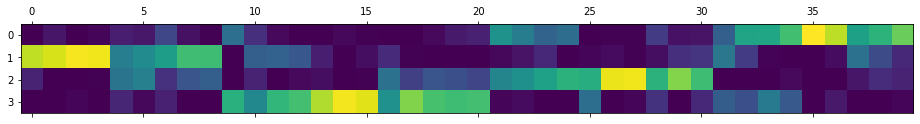

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(40, 50, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': array([3.]), 'allele_prior_alpha': array([1.]), 'allele_prior_beta': array([1.])}


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [21]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                            use_logitnormal_sticks=use_logitnormal_sticks,
                                            seed = 143241)

In [22]:
vb_params_dict

OrderedDict([('pop_freq_beta_params', array([[[ 0.08887812,  1.        ],
                      [ 0.05263158,  1.        ],
                      [ 0.841772  ,  1.        ],
                      [ 0.05263158,  1.        ],
                      [ 2.30421025,  1.        ],
                      [ 0.45945855,  1.        ],
                      [ 0.05263158,  1.        ],
                      [ 0.05263158,  1.        ]],
              
                     [[ 0.07506802,  1.        ],
                      [ 0.21087896,  1.        ],
                      [ 0.05263158,  1.        ],
                      [ 0.05263158,  1.        ],
                      [ 0.05263158,  1.        ],
                      [ 0.25005803,  1.        ],
                      [ 0.19998644,  1.        ],
                      [ 0.05263158,  1.        ]],
              
                     [[ 0.05263158,  1.        ],
                      [ 0.16994138,  1.        ],
                      [ 0.93710435,  1.     

In [12]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            use_logitnormal_sticks,
                            gh_loc, gh_weights)

11000.219328597945

In [13]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

In [14]:
(vb_params_free**2).mean()

2.121936624732062

# Define objective

In [15]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = vb_params_paragami,
                                    free = True,
                                    argnums = 1)

objective_fun = lambda x: objective(g_obs, x, prior_params_dict, 
                                    use_logitnormal_sticks = use_logitnormal_sticks,
                                    gh_loc = gh_loc,
                                    gh_weights = gh_weights)

In [16]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun)
obj_fun_hessian = autograd.hessian(objective_fun)
obj_fun_hvp = autograd.hessian_vector_product(objective_fun)

# Derivative times

In [17]:
# function time
%timeit objective_fun(vb_params_free)

8.61 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
# gradient time
%timeit obj_fun_grad(vb_params_free)

32.8 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit obj_fun_hvp(vb_params_free, vb_params_free)

83.4 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Save results

In [23]:
np.savez(file = './tmp', 
         g_obs = g_obs, 
         vb_params_free = vb_params_free, 
         kl = objective_fun(vb_params_free), 
         kl_grad = obj_fun_grad(vb_params_free), 
         kl_hvp = obj_fun_hvp(vb_params_free, vb_params_free))